-Reading annovar files
--Tumor_Sample_Barcode column not found. Creating sample IDs from filenames
--Extracting tx, exon, txchange and aa-change
-Adding Variant_Type
Finished in 6.178s elapsed (6.119s cpu) 
MAF object generated successfully from ANNOVAR file.

Performing drug interaction search...
Drug interaction data retrieved. Columns: Gene, gene_long_name, category_sources, category 
Column names not standardized — showing first few rows.

Searching for kinase genes with mutations...
Kinase detected: BRAF 
Using column: AAChange.refGene as amino-acid annotation source.

Generating lollipop mutation map → Melanoma_Kinase_MutationMap.pdf 


agg_record_1589544649 
                    2

Lollipop plot saved as: Melanoma_Kinase_MutationMap.pdf 

============ SUMMARY REPORT ============
Kinase visualized:  BRAF 
Top 5 drug interactions:
       Gene                                            gene_long_name
     <char>                                                    <char>
1:     ACHE             ACETYLCHOLINESTERASE (CARTWRIGHT BLOOD GROUP)
2:     ACHE             ACETYLCHOLINESTERASE (CARTWRIGHT BLOOD GROUP)
3:   SLC4A5                          SOLUTE CARRIER FAMILY 4 MEMBER 5
4:   SLC4A5                          SOLUTE CARRIER FAMILY 4 MEMBER 5
5: ADAMTS13 ADAM METALLOPEPTIDASE WITH THROMBOSPONDIN TYPE 1 MOTIF 13
                           category_sources         category
                                     <char>           <char>
1:   HingoraniCasas,HopkinsGroom,RussLampel DRUGGABLE GENOME
2:                                       GO     CELL SURFACE
3:                  RussLampel,HopkinsGroom DRUGGABLE GENOME
4: GuideToPharmacologyGenes,HopkinsGroom,GO      TRANSP

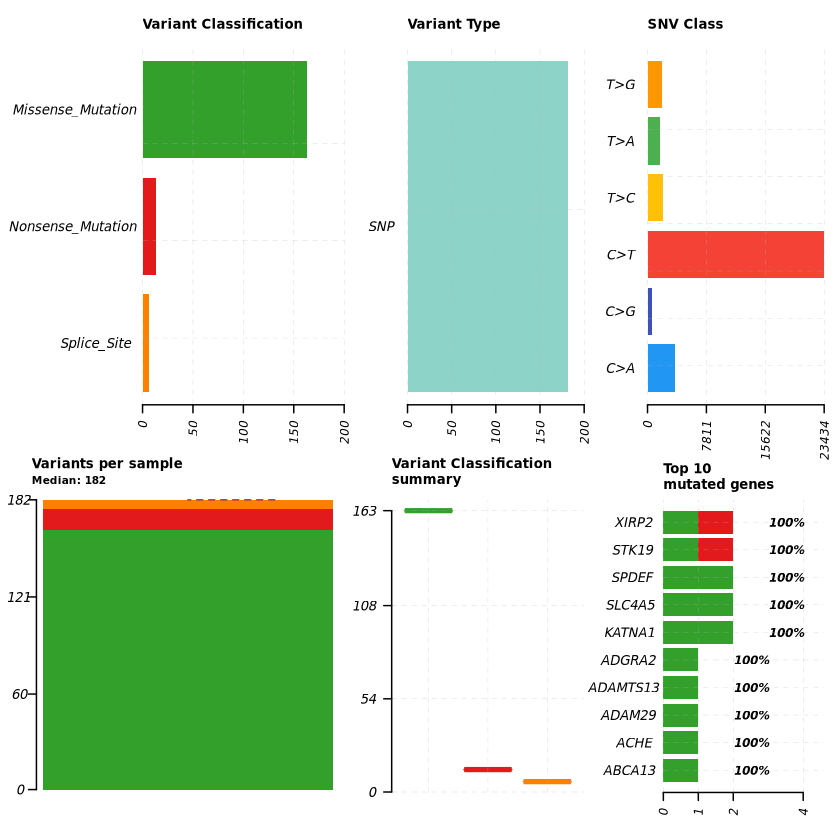

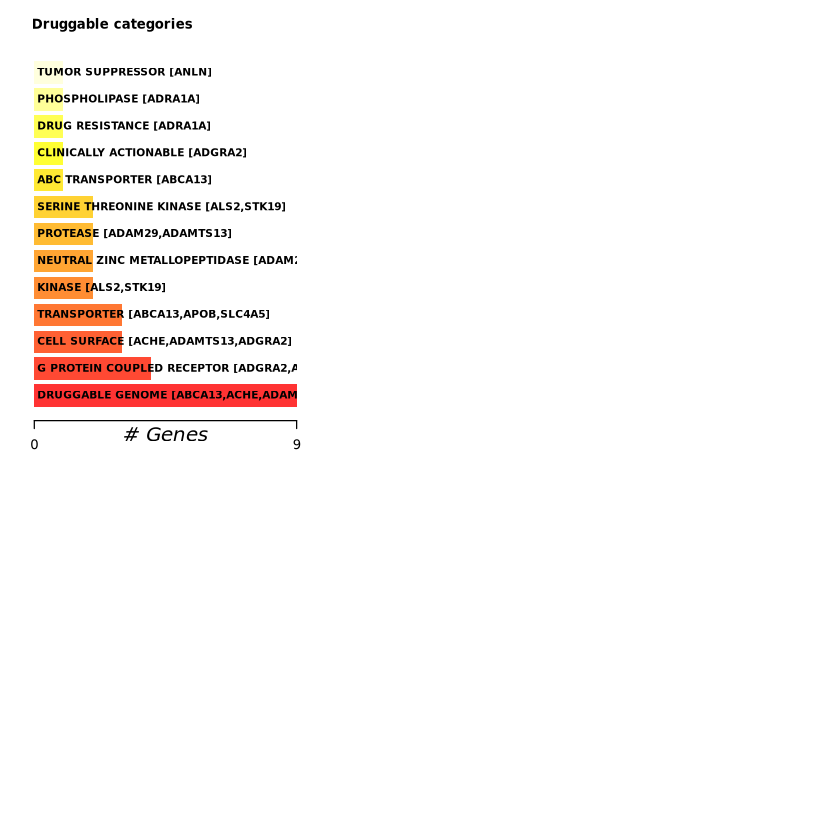

In [1]:
suppressPackageStartupMessages({
  library(maftools)
  library(dplyr)
})

# Step 1. Import ANNOVAR annotation and convert to MAF
input_file <- "sample_melanoma.output.genome_summary.csv"

maf <- annovarToMaf(
  annovar   = input_file,
  refBuild  = "hg19",
  table     = "refGene",
  sep       = ",",
  MAFobj    = TRUE
)
cat("MAF object generated successfully from ANNOVAR file.\n")

# Step 2. Overview of mutation profile
plotmafSummary(maf = maf,
               addStat = "median",
               rmOutlier = TRUE,
               dashboard = TRUE)

# Step 3. Identify top 5 drugs associated with mutated genes
cat("\nPerforming drug interaction search...\n")
drug_data <- tryCatch(drugInteractions(maf), error = function(e) NULL)

if (is.null(drug_data) || nrow(drug_data) == 0) {
  cat("No interaction data available in this dataset.\n")
  top_drugs <- data.frame()
} else {
  cat("Drug interaction data retrieved. Columns:",
      paste(colnames(drug_data), collapse = ", "), "\n")

  g_col <- intersect(c("Hugo_Symbol", "Gene", "gene"), colnames(drug_data))[1]
  d_col <- intersect(c("Drugs", "Drug", "drugs", "drug"), colnames(drug_data))[1]

  if (is.na(g_col) || is.na(d_col)) {
    cat("Column names not standardized — showing first few rows.\n")
    top_drugs <- head(drug_data, 5)
  } else {
    expanded <- do.call(rbind, lapply(seq_len(nrow(drug_data)), function(i) {
      g <- as.character(drug_data[[g_col]][i])
      raw <- drug_data[[d_col]][i]
      vals <- if (is.list(raw)) unlist(raw) else unlist(strsplit(as.character(raw), "[,;]"))
      vals <- trimws(vals)
      vals <- vals[vals != "" & !is.na(vals)]
      if (length(vals) == 0) return(NULL)
      data.frame(Gene = g, Drug = vals, stringsAsFactors = FALSE)
    }))

    expanded <- expanded |>
      distinct(Gene, Drug, .keep_all = TRUE) |>
      filter(nchar(Drug) > 0)

    top_drugs <- expanded |>
      group_by(Drug) |>
      summarise(
        RelatedGenes = n_distinct(Gene),
        GeneList = paste(sort(unique(Gene)), collapse = ", "),
        .groups = "drop"
      ) |>
      arrange(desc(RelatedGenes), Drug) |>
      slice_head(n = 5)

    cat("\nTop 5 drug interactions:\n")
    print(top_drugs, row.names = FALSE)
  }
}

# Step 4. Detect kinase and visualize its mutation sites
cat("\nSearching for kinase genes with mutations...\n")

kinase_pool <- c("BRAF", "NRAS", "KIT", "MAP2K1", "MAP2K2", "ERBB2", "EGFR")
mutated <- unique(maf@data$Hugo_Symbol)
target_gene <- kinase_pool[kinase_pool %in% mutated][1]

if (is.na(target_gene)) {
  target_gene <- names(sort(table(maf@data$Hugo_Symbol), decreasing = TRUE))[1]
  cat("No canonical kinase found — fallback to most frequently mutated gene:",
      target_gene, "\n")
} else {
  cat("Kinase detected:", target_gene, "\n")
}

aa_candidates <- c("HGVSp_Short", "AAChange.refGene", "AAChange",
                   "Protein_Change", "Protein_position", "HGVSp")
aa_col <- intersect(aa_candidates, colnames(maf@data))

if (length(aa_col) == 0) {
  stop("Cannot locate an amino-acid change column for lollipop plotting.")
}

AA_use <- aa_col[1]
cat("Using column:", AA_use, "as amino-acid annotation source.\n")

# Step 5. Draw and export lollipop plot as PDF
output_pdf <- "Melanoma_Kinase_MutationMap.pdf"
cat("\nGenerating lollipop mutation map →", output_pdf, "\n")

pdf(output_pdf, width = 10, height = 4)
tryCatch({
  lollipopPlot(
    maf   = maf,
    gene  = target_gene,
    AACol = AA_use,
    showMutationRate = TRUE,
    refSeq = "NM_004333"
  )
}, error = function(e) {
  cat("lollipopPlot failed, generating simple mutation frequency plot instead.\n")
  freq <- sort(table(maf@data$Hugo_Symbol), decreasing = TRUE)
  barplot(head(freq, 10), las = 2, col = "skyblue",
          main = "Top Mutated Genes (Fallback Plot)",
          ylab = "Mutation Count")
})
dev.off()

cat("Lollipop plot saved as:", output_pdf, "\n")

# Step 6. Summary report
cat("\n============ SUMMARY REPORT ============\n")
cat("Kinase visualized: ", target_gene, "\n")
cat("Top 5 drug interactions:\n")
if (nrow(top_drugs) > 0) print(top_drugs)
cat("Lollipop plot exported to:", output_pdf, "\n")
cat("========================================\n")
